<a href="https://colab.research.google.com/github/nicolasyannick/wine-quality-pca-mlr/blob/main/Wine_Quality_PCA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Load the important libraries

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import boxcox

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

## Import the Dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/WineQT.csv')
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [4]:
# Drop the "Id" column
df.drop(columns=['Id'], inplace=True)

In [5]:
df.shape

(1143, 12)

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


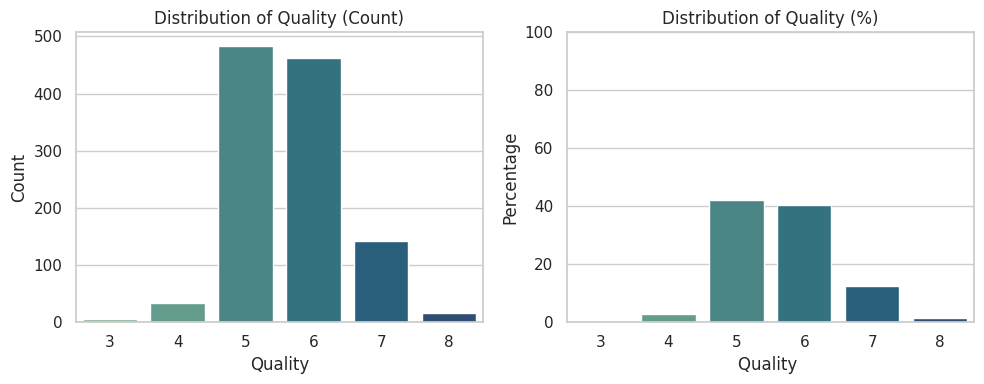

In [7]:
sns.set(style='whitegrid')

quality_class_count = df['quality'].value_counts()
quality_class_percentage = df['quality'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.countplot(data=df, x='quality', palette='crest', ax=axes[0])
axes[0].set_title('Distribution of Quality (Count)')
axes[0].set_xlabel('Quality')
axes[0].set_ylabel('Count')

sns.barplot(x=quality_class_percentage.index, y=quality_class_percentage.values, palette='crest', ax=axes[1])
axes[1].set_title('Distribution of Quality (%)')
axes[1].set_xlabel('Quality ')
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(0, 100)

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

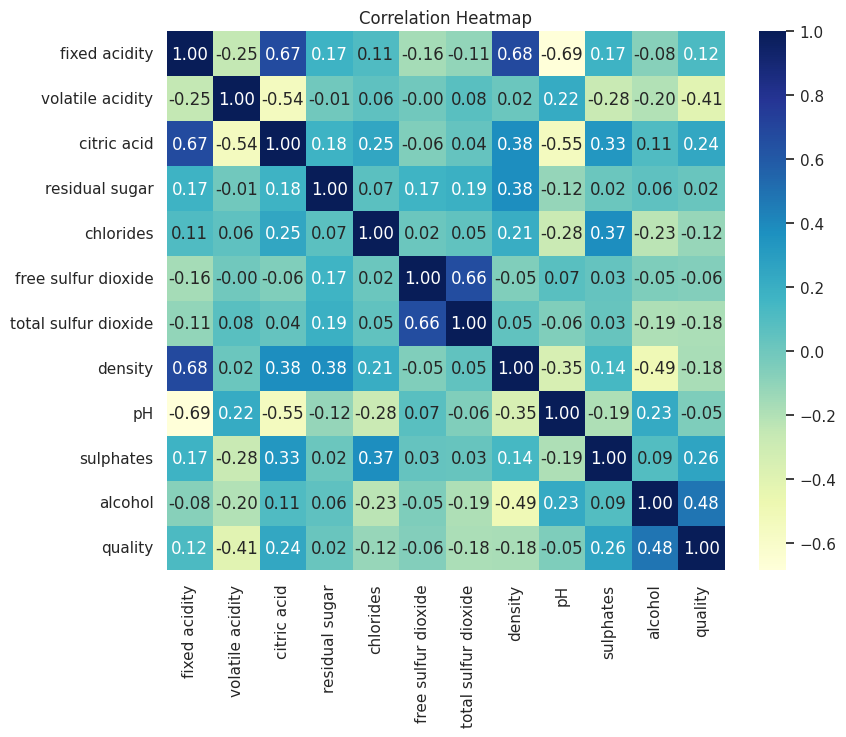

In [8]:
plt.figure(figsize=(9, 7))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="YlGnBu")
plt.title('Correlation Heatmap')
plt.show()

## Outliers

In [9]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df < lower_bound) | (df > upper_bound))
outliers.sum()


fixed acidity            44
volatile acidity         14
citric acid               1
residual sugar          110
chlorides                77
free sulfur dioxide      18
total sulfur dioxide     40
density                  36
pH                       20
sulphates                43
alcohol                  12
quality                  22
dtype: int64

## Removing Oultiers

In [10]:
# Calculate the boolean mask for rows without any outliers
rows_without_outliers = ~outliers.any(axis=1)

# Filter the DataFrame using the mask
df_without_outliers = df[rows_without_outliers]

In [11]:
df_without_outliers.shape

(834, 12)

## Train - Test Split

In [12]:
X = df_without_outliers.iloc[:,:-1]
Y = df_without_outliers.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [13]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
677,8.5,0.470,0.27,1.9,0.058,18.0,38.0,0.99518,3.16,0.85,11.1
509,7.6,0.460,0.11,2.6,0.079,12.0,49.0,0.99680,3.21,0.57,10.0
657,8.6,0.470,0.27,2.3,0.055,14.0,28.0,0.99516,3.18,0.80,11.2
954,7.5,0.510,0.02,1.7,0.084,13.0,31.0,0.99538,3.36,0.54,10.5
445,7.6,0.685,0.23,2.3,0.111,20.0,84.0,0.99640,3.21,0.61,9.3


## Feature Scaling

In [14]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns = [X_train.columns])
X_test_sc = scaler.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns = [X_train.columns])

In [15]:
  X_train_sc.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.248551,-0.375295,0.166857,-0.653617,-1.444447,0.398869,-0.159405,-0.894046,-1.202921,1.892601,0.801467
1,-0.384748,-0.434698,-0.721714,0.890784,0.005902,-0.306822,0.267129,0.123119,-0.838747,-0.534857,-0.341831
2,0.318918,-0.375295,0.166857,0.228898,-1.651640,-0.071592,-0.547164,-0.906604,-1.057251,1.459127,0.905404
3,-0.455114,-0.137685,-1.221534,-1.094874,0.351223,-0.189207,-0.430836,-0.768470,0.253775,-0.794942,0.177850
4,-0.384748,0.901857,-0.055286,0.228898,2.215958,0.634099,1.624284,-0.128033,-0.838747,-0.188077,-1.069385


In [16]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA()

# Fit the PCA model to the standardized data
pca.fit(X_train_sc)

# Get the eigenvalues (explained variance of each principal component)
eigenvalues = pca.explained_variance_

# Convert eigenvalues to a DataFrame for easier interpretation (optional)
eigenvalues_df = pd.DataFrame(eigenvalues, columns=['Eigenvalues'])

# Print eigenvalues
print("Eigenvalues of each principal component:")
print(eigenvalues_df)

Eigenvalues of each principal component:
    Eigenvalues
0      2.910746
1      2.222995
2      1.605883
3      1.100012
4      0.897301
5      0.676338
6      0.608623
7      0.386899
8      0.353196
9      0.190304
10     0.064219


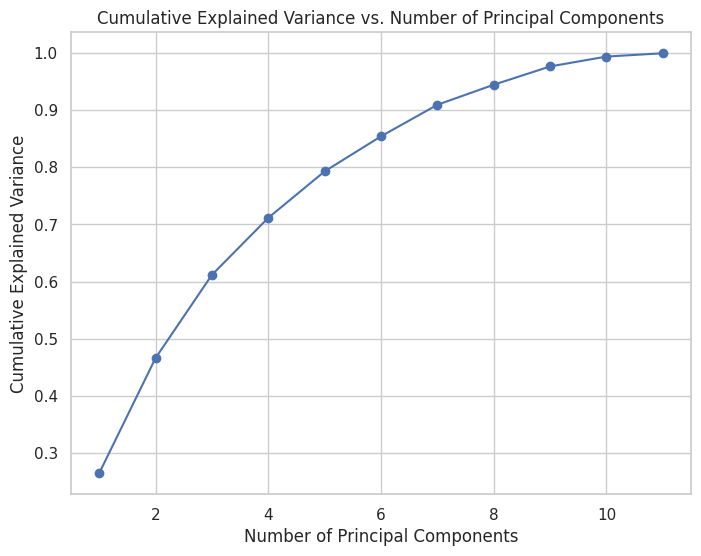

In [17]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance against the number of principal components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [18]:
# Calculate the covariance matrix of the standardized data
cov_matrix = np.cov(X_train_sc, rowvar=False)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

order_of_importance = np.argsort(eigenvalues)[::-1]
print(order_of_importance)

[ 0  1  2  3  4  7  8  9 10  6  5]


## Keeping Top 7 most important columns only

In [19]:
# Calculate the top 7 indices of importance based on order_of_importance
top_7_indices = order_of_importance[:7]

# Get the top 7 most important columns based on the top 7 indices
top_7_columns = X_train.columns[top_7_indices]

# Select the top 7 columns from the DataFrame
X_train_7 = X_train_sc[top_7_columns]

## Multiple Linear Regression Model for 7 Components only

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

model_1 = LinearRegression()
model_1.fit(X_train_7,Y_train)


X_test_7 = X_test_sc[top_7_columns]

Y_pred = model_1.predict(X_test_7)


# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate R-squared (R²)
r2 = r2_score(Y_test, Y_pred)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(Y_test, Y_pred)

# Print the performance metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Mean Absolute Error (MAE):", mae)




Mean Squared Error (MSE): 0.4083590241132863
R-squared (R²): 0.1497144375470032
Mean Absolute Error (MAE): 0.5324719461504918


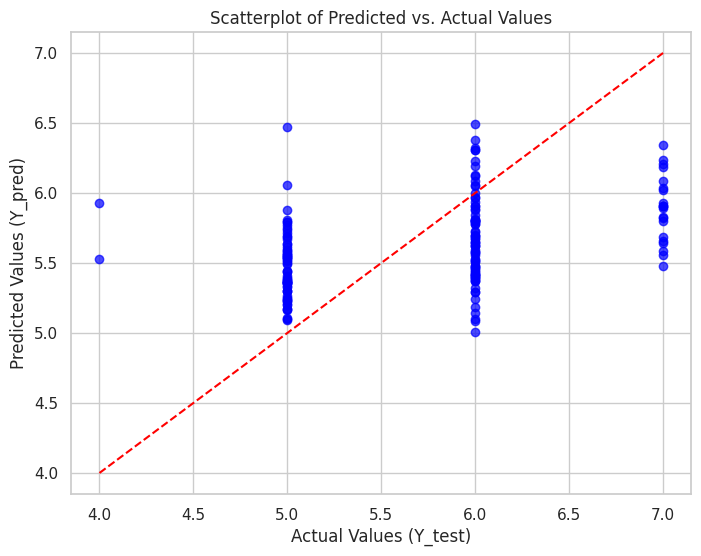

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.7, color='blue')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values (Y_test)')
plt.ylabel('Predicted Values (Y_pred)')
plt.title('Scatterplot of Predicted vs. Actual Values')
plt.show()

## Multiple Linear Regression with all features

In [22]:
model_2 = LinearRegression()
model_2.fit(X_train_sc,Y_train)


Y_pred = model_2.predict(X_test_sc)


# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate R-squared (R²)
r2 = r2_score(Y_test, Y_pred)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(Y_test, Y_pred)

# Print the performance metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.30345170082408485
R-squared (R²): 0.36815256948761366
Mean Absolute Error (MAE): 0.43927436931933656


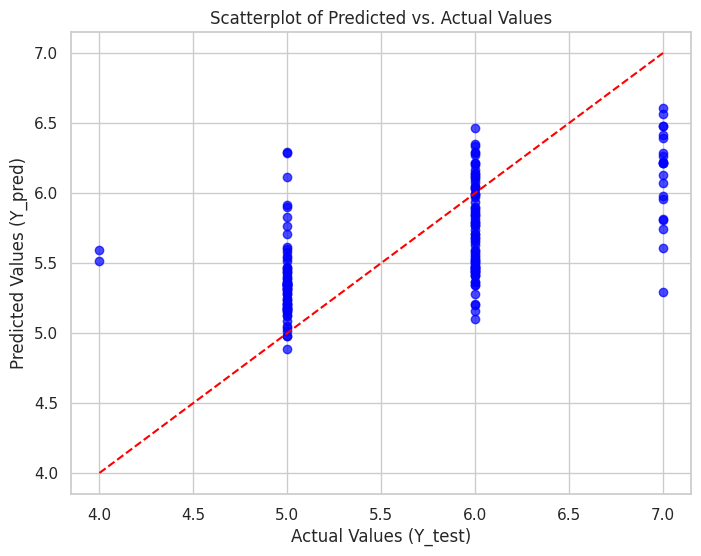

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.7, color='blue')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values (Y_test)')
plt.ylabel('Predicted Values (Y_pred)')
plt.title('Scatterplot of Predicted vs. Actual Values')
plt.show()